# Assignment 8

### Geoffrey Lamb, Jiaqi Yu, Jialin Yu, Matthew Lipinski, Davis Nyabuti, Huiyu He, Tong Wu

#### SEIS 735-01 

#### November 3rd, 2017

# Tree Model


# Tool Selection

## GraphLab

We used `graphlab` to pre-process the data. We chose graphlab for data pre-processing because it uses out of core data structures. This allows the application to load large files without running out of memory.

In total our dataset had a total of 2326856 rows with 17 variables. All variables except for **AGE** are categorical

## R

`R` has a rich library of predictive modeling algorithms which are well documented. It is also an easy to use language with good documentation.


## Required R packages

The following are the R packages are used in the application

In [1]:
options(java.parameters="-Xmx10g")
library (plyr)
library(rpart)
library(caret)
library(corrplot)
library(e1071)
library(data.table)
library(rpart.plot)

Loading required package: lattice
Loading required package: ggplot2
corrplot 0.84 loaded


## Load Data

In [2]:
# data
data <- fread('assignment_8_data.csv',sep = ",",header = T)

'%!in%' <- function(x,y)!('%in%'(x,y))

numeric_cols <- names(data) %in%  c("AGE")
non_numeric <- names(data) %!in% c("AGE","DESYNPUF_ID")
non_numeric <- names(data)[non_numeric]
non_numeric <- unlist(non_numeric, recursive = TRUE, use.names = FALSE)
df <- as.data.frame(data)

Read 2326856 rows and 18 (of 18) columns from 0.128 GB file in 00:00:05


### Decode values

In [3]:
# Make values easy to read
df$SP_DEPRESSN <- as.character(df$SP_DEPRESSN)
df$SP_DEPRESSN[df$SP_DEPRESSN == "1"] <- 'Yes'
df$SP_DEPRESSN[df$SP_DEPRESSN == "2"] <- 'No'
df$BENE_ESRD_IND[df$BENE_ESRD_IND == "0"] <- 'No'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "1"] <- 'Yes'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "2"] <- 'No'
df$SP_CHF[df$SP_CHF == "1"] <- 'Yes'
df$SP_CHF[df$SP_CHF == "2"] <- 'No'
df$SP_CNCR[df$SP_CNCR == "1"] <- 'Yes'
df$SP_CNCR[df$SP_CNCR == "2"] <- 'No'
df$SP_COPD[df$SP_COPD == "1"] <- 'Yes'
df$SP_COPD[df$SP_COPD == "2"] <- 'No'
df$SP_DIABETES[df$SP_DIABETES == "1"] <- 'Yes'
df$SP_DIABETES[df$SP_DIABETES == "2"] <- 'No'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "1"] <- 'Yes'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "2"] <- 'No'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "1"] <- 'Yes'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "2"] <- 'No'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "1"] <- 'Yes'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "2"] <- 'No'
df$SP_RA_OA[df$SP_RA_OA == "1"] <- 'Yes'
df$SP_RA_OA[df$SP_RA_OA == "2"] <- 'No'
df$SP_STRKETIA [df$SP_STRKETIA  == "1"] <- 'Yes'
df$SP_STRKETIA [df$SP_STRKETIA  == "2"] <- 'No'


By default the `read.csv(...)` function loaded all our predictors as numeric. However, some of these predictors are simply IDs that we need to convert to `factors`.

In order to fit the data into our model, the `train` function in the `caret` library expects the `predictors` and the `solution` to be in one dataframe. We will create a new dataframe called `clickTrainData`

In [4]:
# create factors
df[non_numeric] <- lapply(df[non_numeric], factor)

data_y = df$SP_DEPRESSN
names(data_y) <- c("SP_DEPRESSN")

# Remove DESYNPUF_ID and SP_DEPRESSN from df
data_x = df[,non_numeric]
target_name <- names(data_x) %in% c("SP_DEPRESSN")
data_x = data_x[,!target_name]
data_x$AGE = df$AGE

data_xy = data_x
data_xy$SP_DEPRESSN = data_y

rm(data_x)
rm(data_y)
rm(df)
rm(data)
gc()

set.seed(1011)
# idx <- createFolds(data_y, returnTrain = TRUE)
ctrl <- trainControl(method = "cv", savePredictions = TRUE
                    ,summaryFunction = twoClassSummary)

used     (Mb)  gc trigger (Mb)  max used  (Mb) 
Ncells  2196166 117.3   6861544  366.5   4705824 251.4
Vcells 25151498 191.9 106012404  808.9 131053010 999.9

### High level data analysis

We use the `str(...)` function to view the structure of the data

In [5]:
str(data_xy)

'data.frame':	2326856 obs. of  17 variables:
 $ BENE_SEX_IDENT_CD: Factor w/ 2 levels "F","M": 2 2 2 2 1 1 1 2 2 1 ...
 $ BENE_RACE_CD     : Factor w/ 4 levels "Black","Hispanic",..: 4 4 4 4 4 4 4 4 1 1 ...
 $ BENE_ESRD_IND    : Factor w/ 2 levels "No","Y": 1 1 1 1 2 1 1 1 1 1 ...
 $ SP_STATE_CODE    : Factor w/ 52 levels "1","2","3","4",..: 37 3 16 25 33 10 10 44 1 5 ...
 $ BENE_COUNTY_CD   : Factor w/ 319 levels "0","1","10","11",..: 145 13 119 129 49 10 1 288 94 86 ...
 $ SP_ALZHDMTA      : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 2 1 1 2 ...
 $ SP_CHF           : Factor w/ 2 levels "No","Yes": 2 2 2 1 2 1 1 1 1 2 ...
 $ SP_CHRNKIDN      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 2 2 ...
 $ SP_CNCR          : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 1 ...
 $ SP_COPD          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 1 1 1 1 2 ...
 $ SP_DIABETES      : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 1 1 1 1 ...
 $ SP_ISCHMCHT      : Factor w/ 2 levels "No","Yes": 1 1 1 1 

### Categorical variables

An analysis of the output above indicates that some categorical variabes have too many distinct values to create a sparse matrix. If we have to use these variables we would likely require more data. Additionally, inclusion of these variables would make the training process longer. We opted to remove them from the modeling process.

>**3.Your team can remove up to two columns (i.e. predictors) from your prediction task. Which two predictors your team will choose?**
* BENE_COUNTY_CD
* SP_STATE_CODE

In [6]:
tooManyLevels <- names(data_xy) %in% c("SP_STATE_CODE","BENE_COUNTY_CD")
data_xy <- data_xy[!tooManyLevels]
str(data_xy)

'data.frame':	2326856 obs. of  15 variables:
 $ BENE_SEX_IDENT_CD: Factor w/ 2 levels "F","M": 2 2 2 2 1 1 1 2 2 1 ...
 $ BENE_RACE_CD     : Factor w/ 4 levels "Black","Hispanic",..: 4 4 4 4 4 4 4 4 1 1 ...
 $ BENE_ESRD_IND    : Factor w/ 2 levels "No","Y": 1 1 1 1 2 1 1 1 1 1 ...
 $ SP_ALZHDMTA      : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 2 1 1 2 ...
 $ SP_CHF           : Factor w/ 2 levels "No","Yes": 2 2 2 1 2 1 1 1 1 2 ...
 $ SP_CHRNKIDN      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 2 2 ...
 $ SP_CNCR          : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 1 ...
 $ SP_COPD          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 1 1 1 1 2 ...
 $ SP_DIABETES      : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 1 1 1 1 ...
 $ SP_ISCHMCHT      : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 2 2 1 1 1 ...
 $ SP_OSTEOPRS      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ SP_RA_OA         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 2 ...
 $ SP_STRKETIA      : Fac

### Create Test & Train datasets

In [7]:
set.seed(1011)
trainIndex <- createDataPartition(data_xy$SP_DEPRESSN, p = .7, 
                                  list = FALSE, 
                                  times = 1)
depTrain <- data_xy[ trainIndex,]
depTest  <- data_xy[-trainIndex,]

### Balance Train Data

In order for our model to generate relavant results, we need to balance the training data.

In [8]:
set.seed(1011)
train_bal <- downSample(x =  depTrain[,-ncol(depTrain)],
                       y = depTrain$SP_DEPRESSN)
table(train_bal$Class)


    No    Yes 
292889 292889 

# Recursive partitioning model

Recursive partitioning (`rpart`) is a model that helps us visualize the rules used for classification. This model can perform both regression and classification. As a result, it is a good candidate to use to build a decision tree for predicting depression

In [9]:
start.time <- Sys.time()

# Tune the model
set.seed(1011)
fit <- rpart(Class ~ . ,method="class", data=train_bal)

time.taken <- Sys.time() - start.time

cat("Duration ", time.taken, " seconds")

Duration  25.95643  seconds

In [10]:
printcp(fit)


Classification tree:
rpart(formula = Class ~ ., data = train_bal, method = "class")

Variables actually used in tree construction:
[1] SP_ALZHDMTA SP_DIABETES SP_ISCHMCHT

Root node error: 292889/585778 = 0.5

n= 585778 

        CP nsplit rel error  xerror      xstd
1 0.304801      0   1.00000 1.00289 0.0013066
2 0.053317      1   0.69520 0.69520 0.0012444
3 0.016501      2   0.64188 0.64188 0.0012199
4 0.010000      3   0.62538 0.62538 0.0012114


### Cross-validation results

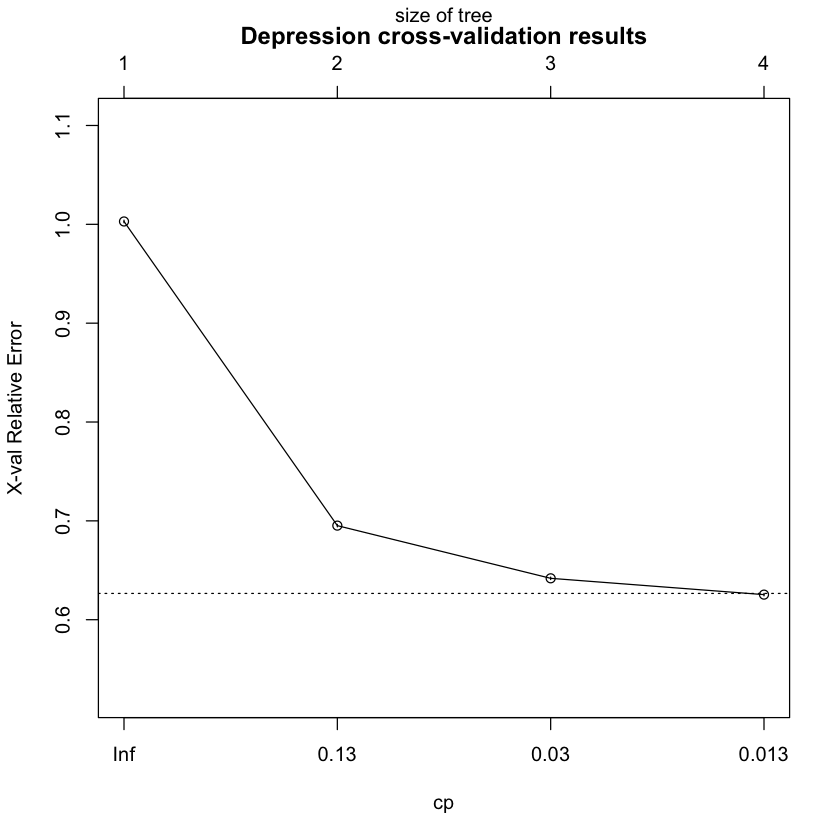

In [11]:
plotcp(fit, main="Depression cross-validation results\n")

## Model Evaluation

In the end the model used 3 of the most important predictors to build a decision tree. These include:
* SP_DIABETES
* SP_ISCHMCHT
* SP_ALZHDMTA

The output includes a confusion matrix of the 

In [12]:
summary(fit)

Call:
rpart(formula = Class ~ ., data = train_bal, method = "class")
  n= 585778 

          CP nsplit rel error    xerror        xstd
1 0.30480148      0 1.0000000 1.0028851 0.001306567
2 0.05331713      1 0.6951985 0.6951985 0.001244400
3 0.01650113      2 0.6418814 0.6418814 0.001219915
4 0.01000000      3 0.6253803 0.6253803 0.001211426

Variable importance
SP_DIABETES SP_ISCHMCHT SP_ALZHDMTA      SP_CHF SP_CHRNKIDN     SP_COPD 
         37          24          13          10           9           6 
   SP_RA_OA 
          1 

Node number 1: 585778 observations,    complexity param=0.3048015
  predicted class=No   expected loss=0.5  P(node) =1
    class counts: 292889 292889
   probabilities: 0.500 0.500 
  left son=2 (354509 obs) right son=3 (231269 obs)
  Primary splits:
      SP_DIABETES splits as  LR, improve=28470.73, (0 missing)
      SP_ISCHMCHT splits as  LR, improve=25302.58, (0 missing)
      SP_CHF      splits as  LR, improve=19346.50, (0 missing)
      SP_ALZHDMTA split

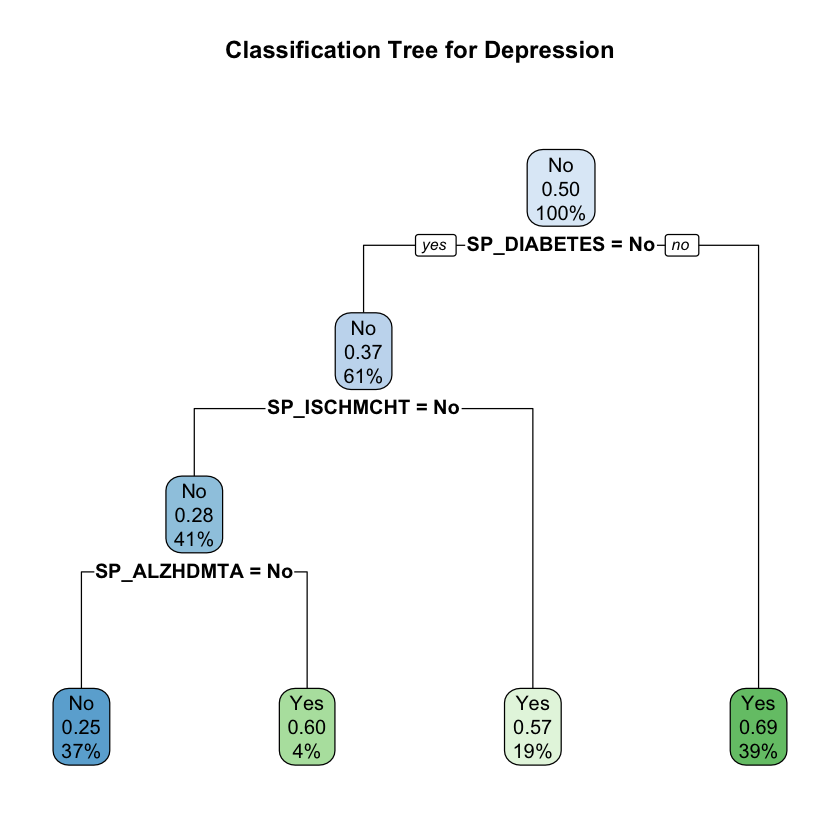

In [13]:
rpart.plot(fit, uniform=TRUE, main="Classification Tree for Depression")

### ROC Curve

To visualize the performance of our model we used the **ROC** curve. The curve is pulling away from the center to the upper left corner meaning that the model performs better than a 50/50 chance of prediction Depression. The AUC is 0.71002

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



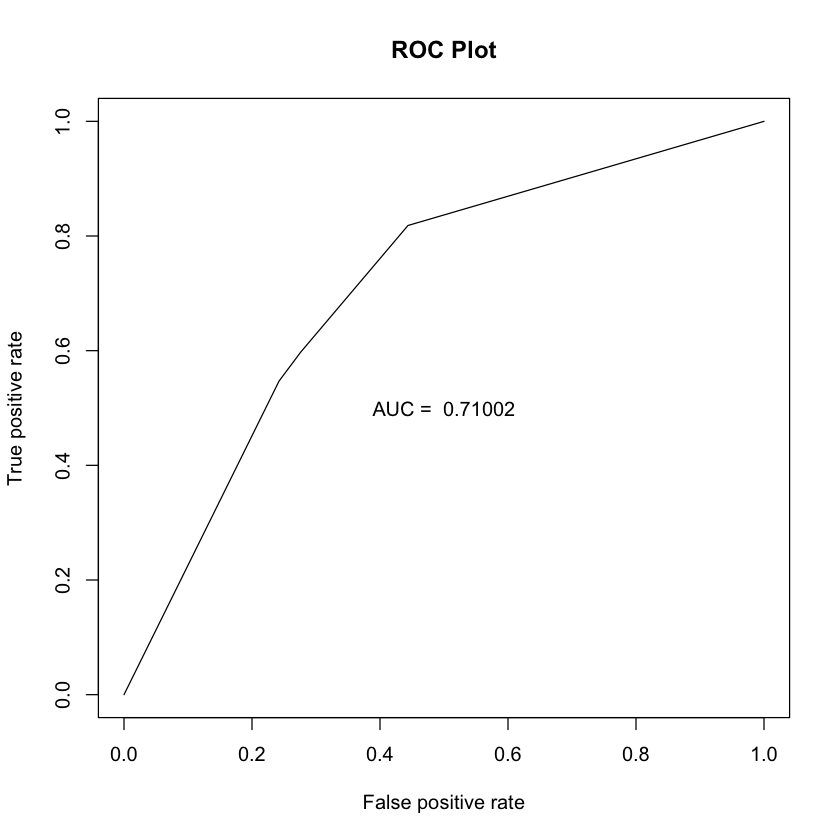

In [14]:
set.seed(1011)
library("ROCR")
pred <- prediction(predict(fit, type = "prob")[, 2], train_bal$Class)
perf_AUC=performance(pred,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
perf <- performance(pred, "tpr", "fpr")
plot(perf, main="ROC Plot")
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

## Confusion Matrix

In [15]:
# confusion matrix (training data)
conf.matrix <- table(train_bal$Class, predict(fit,type="class"))
rownames(conf.matrix) <- paste("Actual", rownames(conf.matrix), sep = ":")
colnames(conf.matrix) <- paste("Pred", colnames(conf.matrix), sep = ":")
print(conf.matrix)


            
             Pred:No Pred:Yes
  Actual:No   162929   129960
  Actual:Yes   53207   239682


## Predict on test data

            
             Pred:No Pred:Yes
  Actual:No   318959    22749
  Actual:Yes  253574   102774


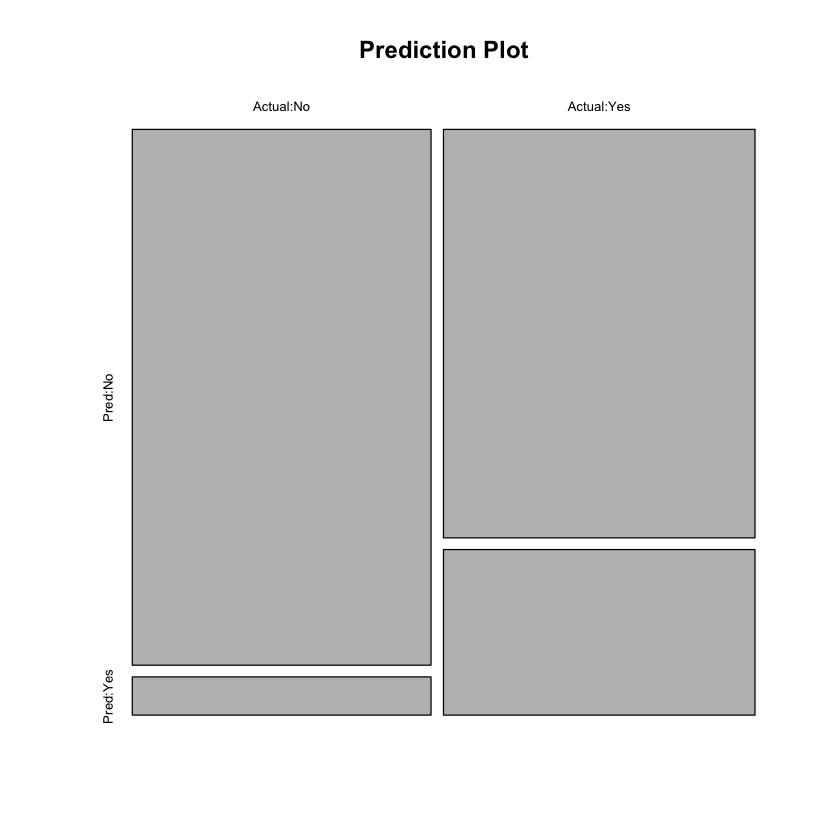

In [16]:
pred <- table(predict(fit, depTest, type = "class"), depTest[, "SP_DEPRESSN"])
rownames(pred) <- paste("Actual", rownames(pred), sep = ":")
colnames(pred) <- paste("Pred", colnames(pred), sep = ":")
print(pred)
plot(pred, main="Prediction Plot")

# Conclusion

The model is good at identifying individuals with no depression. However, its accuracy in predicting depression is less than 50%.

The accuracy of the model could be improved by:

* Tuning the training parameters 
* Use a bagged trees
* Choose between predictors with a high correlation
* Change **AGE** which is numeric into a factor by generating different age groups (range)

In [4]:
?summary